In [13]:
!pip install icecream

In [14]:
import numpy as np                        # Одномерные и многомерные массивы (array)
import pandas as pd                       # Таблицы и временные ряды (dataframe, series)
import matplotlib.pyplot as plt           # Научная графика
import seaborn as sns                     # Еще больше красивой графики для визуализации данных
import sklearn                            # Алгоритмы машинного обучения
import csv                                # Чтение и обработка датасета как локального файла
from tempfile import NamedTemporaryFile   # Временный файл для обработки сырых данных
import shutil                             # Системная утилита для записи временного файла в постоянный
from icecream import ic                   # Отладочная функция, заменяющая собой print (даёт больше информации для отладки)

# **Оценка стоимости квартиры**


#### Переменная, которая указывает на то, является ли этот запуск первым, и нужно ли скачивать и обрабатывать файл исходных данных
Потребуется много времени на скачивание и обработку, поэтому рекомендуется оставлять её в положении True только при первом запуске

In [15]:
is_first_run = False                # Является ли этот запуск ноутбука первичным (нужно ли скачивать и обрабатывать исходные данные)
create_trim_data = is_first_run     # нужно ли создать укороченный датасет для отладки
trim_data_to = 500_000              # до скольки строк нужно сократить датасет
use_trim_data = True                # использовать сокращённый датасет или же полную его версию (требуется создать сокращённый датасет как минимум один раз)
display_plots = False               # нужно ли отображать графики в блоке анализа данных

# 1. Загружаем данные

Загружаем файл из интернета (если это требуется - при первичном запуске):

In [16]:
if is_first_run:
    import kaggle

    kaggle.api.authenticate()
    kaggle.api.dataset_download_file('willianoliveiragibin/uk-property-price-data-1995-2023-04', file_name='202304.csv',  path='data/')

Исходный файл не содержит строки заголовков. Обработаем его и создадим новый файл, который будет содержать все те же данные, но также будет содержать заголовки столбцов в первой строке для корректного вывода в Pandas и Seaborn (если это требуется - при первичном запуске)

In [17]:
if is_first_run:
    tempfile = NamedTemporaryFile('w+t', newline='', delete=False)
    with open("data/202304.csv", 'r', newline='') as file, tempfile:
        reader = csv.reader(file, delimiter=',', quotechar='"')
        writer = csv.writer(tempfile, delimiter=',', quotechar='"')

        header = ['Transaction UUID', 'Price', 'Date of transfer', 'Post code',
                  'Property type', 'Old/New', 'Duration', 'PAON',
                  'SAON', 'Street', 'Locality', 'Town/City',
                  'District', 'County', 'PPD Category type', 'Record status (monthly file only)']

        writer.writerow(header)
        index: int = 0
        for row in reader:
            writer.writerow(row)
            if not create_trim_data:
                continue

            index += 1
            if index >= trim_data_to:
                break

    shutil.move(tempfile.name, "data/202304_header_and_trim.csv" if create_trim_data else "data/202304_header.csv")

Считываем загруженные данные в Pandas

In [18]:
data_raw = pd.read_csv("data/202304_header_and_trim.csv" if use_trim_data else "data/202304_header.csv")

Таблица содержит данные о более 72 тысяч квартир, выставленных на продажу в г.Нижнем Новгороде в 2017 г. Для каждой квартиры указаны ее цена (в тыс. руб.), географические координаты, тип продажи (вторичка или новостройка), количество этажей, тип дома, количество комнат (0 - квартира-студия), номер этажа и общая площадь квартиры (в кв.м).

Вначале посмотрим на размеры таблицы: количество строк (каждая строка соответствует одной квартире) и количество столбцов (каждый столбец соответствует конкретному признаку):

In [19]:
data_raw.shape

(50000, 16)

In [20]:
data_raw

Transaction UUID  Price  Date of transfer  \
0      {F887F88E-7D15-4415-804E-52EAC2F10958}  70000  1995-07-07 00:00   
1      {40FD4DF2-5362-407C-92BC-566E2CCE89E9}  44500  1995-02-03 00:00   
2      {7A99F89E-7D81-4E45-ABD5-566E49A045EA}  56500  1995-01-13 00:00   
3      {28225260-E61C-4E57-8B56-566E5285B1C1}  58000  1995-07-28 00:00   
4      {444D34D7-9BA6-43A7-B695-4F48980E0176}  51000  1995-06-28 00:00   
...                                       ...    ...               ...   
49995  {92E08CE3-6C99-4AF9-A594-955DC174D7E5}  67000  1995-04-21 00:00   
49996  {D90390D4-DFAB-4D0F-93F1-955DD428E999}  88450  1995-06-30 00:00   
49997  {092974D1-0681-4CEB-86CC-9FFBCA1EA730}  54000  1995-08-30 00:00   
49998  {829477B0-F3BA-43A5-9018-9FFBDA1D00DA}  58500  1995-09-14 00:00   
49999  {64478563-527B-4714-BB7C-A38EC9DD5B9B}  76000  1995-05-26 00:00   

      Post code Property type Old/New Duration PAON    SAON            Street  \
0      MK15 9HP             D       N        F   31     NaN     ALDRICH DRIVE   
1       SR6 0AQ             T       N        F   50     NaN       HOWICK PARK   
2       CO6 1SQ             T       N        F   19     NaN  BRICK KILN CLOSE   
3       B90 4TG             T       N        F   37     NaN  RAINSBROOK DRIVE   
4       DY5 1SA             S       N        F   59     NaN        MERRY HILL   
...         ...           ...     ...      ...  ...     ...               ...   
49995  BS14 9AE             S       N        F   18     NaN     IMPERIAL WALK   
49996   M33 5ZA             D       Y        F    1     NaN    AYSGARTH CLOSE   
49997  SO30 0NG             S       N        F   51     NaN   WOODSTOCK CLOSE   
49998  LL19 9DT             S       N        F   35     NaN      GRONANT ROAD   
49999   RG4 7AX             F       N        L   18  FLAT 1    ST PETERS HILL   

            Locality      Town/City       District              County  \
0             WILLEN  MILTON KEYNES  MILTON KEYNES       MILTON KEYNES   
1         SUNDERLAND     SUNDERLAND     SUNDERLAND       TYNE AND WEAR   
2         COGGESHALL     COLCHESTER      BRAINTREE               ESSEX   
3            SHIRLEY       SOLIHULL       SOLIHULL       WEST MIDLANDS   
4      BRIERLEY HILL  BRIERLEY HILL         DUDLEY       WEST MIDLANDS   
...              ...            ...            ...                 ...   
49995        BRISTOL        BRISTOL        BRISTOL                AVON   
49996           SALE           SALE       TRAFFORD  GREATER MANCHESTER   
49997      HEDGE END    SOUTHAMPTON      EASTLEIGH           HAMPSHIRE   
49998      PRESTATYN      PRESTATYN       RHUDDLAN               CLWYD   
49999      CAVERSHAM        READING        READING             READING   

      PPD Category type Record status (monthly file only)  
0                     A                                 A  
1                     A                                 A  
2                     A                                 A  
3                     A                                 A  
4                     A                                 A  
...                 ...                               ...  
49995                 A                                 A  
49996                 A                                 A  
49997                 A                                 A  
49998                 A                                 A  
49999                 A                                 A  

[50000 rows x 16 columns]

In [21]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 16 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   Transaction UUID                   50000 non-null  object
 1   Price                              50000 non-null  int64 
 2   Date of transfer                   50000 non-null  object
 3   Post code                          49965 non-null  object
 4   Property type                      50000 non-null  object
 5   Old/New                            50000 non-null  object
 6   Duration                           50000 non-null  object
 7   PAON                               49995 non-null  object
 8   SAON                               3890 non-null   object
 9   Street                             49234 non-null  object
 10  Locality                           47965 non-null  object
 11  Town/City                          50000 non-null  object
 12  Dist

Мы видим, что столбцы (признаки) имеют имена

- `Transaction UUID` - уникальный номер транзакции
- `Price` - цена квартиры (фунты стерлинги)
- `Date of transfer` - дата оплаты
- `Post code` - почтовый индекс, к которому принадлежит квартира
- `Property type` - тип собственности (квартира/собственный дом/особняк и т.д.)
- `Old/New` - является ли собственность новостройкой или уже эксплуатируемой
- `Duration` - срок аренды (если собственность не продаётся полностью)
- `PAON` - Primary adress, основной адрес - номер или название дома
- `SAON` - Secondary adress, дополнительный адрес - дополнительная информация об адресе, если собственность является частью другого строения
- `Street` - улица, на которой находится дом
- `Locality` - дополнительная информация о локации
- `Town/City` - город, в котором располагается собственность
- `District` - район
- `County` - округ
- `PPD Category type` - категория типа оплаты сделки
- `Record status (monthly file only)` - текущий статус аренды для квартир

Признак `Building` - номинальный (категориальный), `Type` - бинарный, остальные признаки (включая целевой признак `Price`) - количественный (числовой).

Требуется предсказать количественный признак `Price` по остальным признакам. Это *задача восстановления регрессии*.

Расшифтовка значений признака `'Property type'`:
- $D$ = $Detached$ (частный дом / отдельное здание - всё здание в собственности)
- $S$ = $Semi-Detached$ (двухквартирный дом)
- $T$ = $Terraced$ (террасный дом)
- $F$ = $Flats/Maisonettes$ (квартира)
- $O$ = $Other$ (другие типы недвижимости)

Типы признаков:

- Качественные (*категориальные*, *факторные*):
  - Неупорядоченные (*номинальные*)
  - Упорядоченные (*порядковые*)
- Количественные (*числовые*):
  - *Непрерывные*
  - *Дискретные*

*Бинарные* признаки (которые принимают только два значения) можно считать и номинальными, и порядковыми, и дискретными    

Столбцы `'Old/New'`, `'PPD Category type'`, `'Property type'`, `'Duration'` и `'Record status (monthly file only)'` содержат категориальные значения. Пока они имеют тип `'Object`'. Заменим тип на специальный, предназначенный для хранения категориальных значений:

In [22]:
data_raw['Old/New'] = data_raw['Old/New'].astype('category')
data_raw['PPD Category type'] = data_raw['PPD Category type'].astype('category')
data_raw['Property type'] = data_raw['Property type'].astype('category')
data_raw['Duration'] = data_raw['Duration'].astype('category')
data_raw['Record status (monthly file only)'] = data_raw['Record status (monthly file only)'].astype('category')

In [23]:
ic(data_raw['Old/New'].dtype)
ic(data_raw['PPD Category type'].dtype)
ic(data_raw['Property type'].dtype)
ic(data_raw['Duration'].dtype)
ic(data_raw['Record status (monthly file only)'].dtype)
0

ic| data_raw['Old/New'].dtype: CategoricalDtype(categories=['N', 'Y'], ordered=False)
ic| data_raw['PPD Category type'].dtype: CategoricalDtype(categories=['A'], ordered=False)
ic| data_raw['Property type'].dtype: CategoricalDtype(categories=['D', 'F', 'S', 'T'], ordered=False)
ic| data_raw['Duration'].dtype: CategoricalDtype(categories=['F', 'L', 'U'], ordered=False)
ic| data_raw['Record status (monthly file only)'].dtype: CategoricalDtype(categories=['A'], ordered=False)


0

Здесь мы видим, что столбец `'Record status (monthly file only)'` содержит лишь одно уникальное значение, идентичное для абсолютно всех записей датасета. Следовательно, эти данные бесполезны для дальнейшего обучения - их можно отсеять

В то же время поле `'Transaction UUID'` является уникальным для каждой строки и также не коррелирует с характеристиками недвижимости - его тоже можно отсеять

Поле `'Post code'` не подлежит корректному численному кодированию, потому от него мы также отказываемся

In [24]:
data_raw = data_raw.drop(['Record status (monthly file only)', 'Transaction UUID', 'Post code'], axis=1)

Выведем полученные данные

In [25]:
data_raw.sample(10)

Price  Date of transfer Property type Old/New Duration PAON SAON  \
15891  132000  1995-11-30 00:00             T       N        F   30  NaN   
42262   89000  1995-01-12 00:00             D       N        F    3  NaN   
37756   43500  1995-08-25 00:00             T       N        F   69  NaN   
12700   98250  1995-08-11 00:00             D       Y        F   25  NaN   
3339    26500  1995-08-25 00:00             S       N        F   42  NaN   
32418   70950  1995-06-14 00:00             D       Y        F    6  NaN   
9160     8000  1995-12-20 00:00             T       N        F   54  NaN   
19039   79500  1995-02-10 00:00             T       N        F   21  NaN   
29129  171000  1995-08-31 00:00             D       N        F    9  NaN   
47927   46000  1995-11-30 00:00             T       N        F   32  NaN   

                  Street        Locality       Town/City        District  \
15891        CURZON ROAD          LONDON          LONDON          EALING   
42262       WALNUT CLOSE           ROWDE         DEVIZES          KENNET   
37756    WELLESLEY CLOSE        ASH VALE       ALDERSHOT       GUILDFORD   
12700     NICHOLDS CLOSE         COSELEY         BILSTON          DUDLEY   
3339       FAIRLYN DRIVE         BRISTOL         BRISTOL       KINGSWOOD   
32418  CARLTON MOOR MEWS           LEEDS           LEEDS           LEEDS   
9160     TREHARNE STREET        TREORCHY        TREORCHY         RHONDDA   
19039      SUNRAY AVENUE         BROMLEY         BROMLEY         BROMLEY   
29129    FAIRFIELD CLOSE       LYMINGTON       LYMINGTON      NEW FOREST   
47927       WELDON CLOSE  WELLINGBOROUGH  WELLINGBOROUGH  WELLINGBOROUGH   

                 County PPD Category type  
15891    GREATER LONDON                 A  
42262         WILTSHIRE                 A  
37756            SURREY                 A  
12700     WEST MIDLANDS                 A  
3339               AVON                 A  
32418    WEST YORKSHIRE                 A  
9160      MID GLAMORGAN                 A  
19039    GREATER LONDON                 A  
29129         HAMPSHIRE                 A  
47927  NORTHAMPTONSHIRE                 A

Информация о числовых признаках:

In [26]:
data_raw.describe()

Price
count  5.000000e+04
mean   6.798588e+04
std    5.652677e+04
min    1.500000e+02
25%    3.950000e+04
50%    5.500000e+04
75%    7.850000e+04
max    2.520000e+06

В полных данных минимальная цена в исходных данных - 1 фунт стерлинг, что является выбросом. Позже вернёмся к обработке данных

Информация о категориальных признаках

In [27]:
data_raw.describe(include=['category'])

Property type Old/New Duration PPD Category type
count          50000   50000    50000             50000
unique             4       2        3                 1
top                T       N        F                 A
freq           15783   43378    40252             50000

## Пропущенные значения:

In [28]:
data_raw.isnull()

Price  Date of transfer  Property type  Old/New  Duration   PAON  \
0      False             False          False    False     False  False   
1      False             False          False    False     False  False   
2      False             False          False    False     False  False   
3      False             False          False    False     False  False   
4      False             False          False    False     False  False   
...      ...               ...            ...      ...       ...    ...   
49995  False             False          False    False     False  False   
49996  False             False          False    False     False  False   
49997  False             False          False    False     False  False   
49998  False             False          False    False     False  False   
49999  False             False          False    False     False  False   

        SAON  Street  Locality  Town/City  District  County  PPD Category type  
0       True   False     False      False     False   False              False  
1       True   False     False      False     False   False              False  
2       True   False     False      False     False   False              False  
3       True   False     False      False     False   False              False  
4       True   False     False      False     False   False              False  
...      ...     ...       ...        ...       ...     ...                ...  
49995   True   False     False      False     False   False              False  
49996   True   False     False      False     False   False              False  
49997   True   False     False      False     False   False              False  
49998   True   False     False      False     False   False              False  
49999  False   False     False      False     False   False              False  

[50000 rows x 13 columns]

Количество пропущенных значиний для каждого из признаков:

In [29]:
data_raw.isnull().sum()

Price                    0
Date of transfer         0
Property type            0
Old/New                  0
Duration                 0
PAON                     5
SAON                 46110
Street                 766
Locality              2035
Town/City                0
District                 0
County                   0
PPD Category type        0
dtype: int64

Список признаков, значения в которых пропущены:

In [30]:
[feature for feature in data_raw.columns if data_raw[feature].isnull().sum() > 0]

['PAON', 'SAON', 'Street', 'Locality']

Как видим, строк с пропущенными значениями очень много (особенно это касается поля SAON, где пропущено 24 миллиона строк из 28 миллионов исходных - оно и понятно по назначению этого поля, далеко не у всех домов есть "второй адрес" - дополнительной информации о локации. Зачастую достаточно поля PAON для описания адреса

Удаление строк с пропущенными значениями приведёт к колоссальной потере данных, эти пустые значения стоит обрабатывать иначе

# 2. Преобразуем данные в числовые
Для более качественного описания поле `'Date of transfer'` можно разбить на два столбца - год совершения транзакции (поскольку цены на недвижимость растут со временем) и месяц (поскольку цены также могут меняться в зависимости от сезона). Остальными данными можно пренебречь, поэтому после получения новых столбцов исходный удалим

$Предупреждение$: При использовании укороченного (отладочного) датасета год может оказаться уникальным значением, поскольку транзакции сгруппированы по годам. Например, при использовании первых $500 000$ значений **все** строки имеют значение 1995. Однако при использовании полного датасета это поле не является бесполезным

In [31]:
from datetime import datetime
format = "%Y-%m-%d %H:%M"
data_raw['Year of transfer'] = data_raw['Date of transfer'].apply(lambda date: int(datetime.strptime(date, format).year))
data_raw['Month of transfer'] = data_raw['Date of transfer'].apply(lambda date: int(datetime.strptime(date, format).month))

data_raw = data_raw.drop('Date of transfer', axis=1)

data_raw.head(5)

Price Property type Old/New Duration PAON SAON            Street  \
0  70000             D       N        F   31  NaN     ALDRICH DRIVE   
1  44500             T       N        F   50  NaN       HOWICK PARK   
2  56500             T       N        F   19  NaN  BRICK KILN CLOSE   
3  58000             T       N        F   37  NaN  RAINSBROOK DRIVE   
4  51000             S       N        F   59  NaN        MERRY HILL   

        Locality      Town/City       District         County  \
0         WILLEN  MILTON KEYNES  MILTON KEYNES  MILTON KEYNES   
1     SUNDERLAND     SUNDERLAND     SUNDERLAND  TYNE AND WEAR   
2     COGGESHALL     COLCHESTER      BRAINTREE          ESSEX   
3        SHIRLEY       SOLIHULL       SOLIHULL  WEST MIDLANDS   
4  BRIERLEY HILL  BRIERLEY HILL         DUDLEY  WEST MIDLANDS   

  PPD Category type  Year of transfer  Month of transfer  
0                 A              1995                  7  
1                 A              1995                  2  
2                 A              1995                  1  
3                 A              1995                  7  
4                 A              1995                  6

## 2. Визуализируем, анализируем, боремся с выбросами (outliers)

Для дальнейшего построения диаграм по категорийным признакам преобразуем эти признаки в числовыеse)

In [32]:
data_raw['Old/New'] = data_raw['Old/New'].apply(lambda on: "YN".index(on)).astype('int64')
data_raw['PPD Category type'] = data_raw['PPD Category type'].apply(lambda ppd: "AB".index(ppd)).astype('int64')
data_raw['Property type'] = data_raw['Property type'].apply(lambda pt: "DSTFO".index(pt)).astype('int64')
data_raw['Duration'] = data_raw['Duration'].apply(lambda dur: "FLU".index(dur)).astype('int64')

In [33]:
data_raw

Price  Property type  Old/New  Duration PAON    SAON            Street  \
0      70000              0        1         0   31     NaN     ALDRICH DRIVE   
1      44500              2        1         0   50     NaN       HOWICK PARK   
2      56500              2        1         0   19     NaN  BRICK KILN CLOSE   
3      58000              2        1         0   37     NaN  RAINSBROOK DRIVE   
4      51000              1        1         0   59     NaN        MERRY HILL   
...      ...            ...      ...       ...  ...     ...               ...   
49995  67000              1        1         0   18     NaN     IMPERIAL WALK   
49996  88450              0        0         0    1     NaN    AYSGARTH CLOSE   
49997  54000              1        1         0   51     NaN   WOODSTOCK CLOSE   
49998  58500              1        1         0   35     NaN      GRONANT ROAD   
49999  76000              3        1         1   18  FLAT 1    ST PETERS HILL   

            Locality      Town/City       District              County  \
0             WILLEN  MILTON KEYNES  MILTON KEYNES       MILTON KEYNES   
1         SUNDERLAND     SUNDERLAND     SUNDERLAND       TYNE AND WEAR   
2         COGGESHALL     COLCHESTER      BRAINTREE               ESSEX   
3            SHIRLEY       SOLIHULL       SOLIHULL       WEST MIDLANDS   
4      BRIERLEY HILL  BRIERLEY HILL         DUDLEY       WEST MIDLANDS   
...              ...            ...            ...                 ...   
49995        BRISTOL        BRISTOL        BRISTOL                AVON   
49996           SALE           SALE       TRAFFORD  GREATER MANCHESTER   
49997      HEDGE END    SOUTHAMPTON      EASTLEIGH           HAMPSHIRE   
49998      PRESTATYN      PRESTATYN       RHUDDLAN               CLWYD   
49999      CAVERSHAM        READING        READING             READING   

       PPD Category type  Year of transfer  Month of transfer  
0                      0              1995                  7  
1                      0              1995                  2  
2                      0              1995                  1  
3                      0              1995                  7  
4                      0              1995                  6  
...                  ...               ...                ...  
49995                  0              1995                  4  
49996                  0              1995                  6  
49997                  0              1995                  8  
49998                  0              1995                  9  
49999                  0              1995                  5  

[50000 rows x 14 columns]

In [34]:
if display_plots:
    data_raw.plot(kind='scatter', x='Old/New', y='Price')
pass

Все диаграммы рассеивания:

In [35]:
if display_plots:
    pd.plotting.scatter_matrix(data_raw, figsize = (10, 8))
pass

Категорийные признаки выбросов не содержат. Исходя из диаграммы выше, поле Дата транзакции также не содержит выбросов. Однако под вопросом остаётся поле `'Price'`, минимальное значение которого составляет 1 фунт стерлинг

Для обнаружения выбросов найдем квантили для этого признака:

In [36]:
if display_plots:
    data_raw['Price'].plot(kind='box')
pass

In [37]:
data_raw['Price'].quantile([0.005,.01,.05,.1,.5,.9,.95,.99,.995])

0.005     10000.00
0.010     13000.00
0.050     22500.00
0.100     28500.00
0.500     55000.00
0.900    119000.00
0.950    154000.00
0.990    275000.00
0.995    350009.69
Name: Price, dtype: float64

Мы видим, например, что $99\%$ всех значений признака `'Price'` находится в диапазоне от $10.000$ до $350.000$ фунтов стерлингов (это значения квантилей, соответствующих уровням $0.005$ и $0.995$ соответственно)

Удалим все строки таблицы, в которых `'Price'` выходит за пределы квантилей $0.005$, $0.995$.

In [38]:
rows_to_drop = data_raw[
    (data_raw['Price'] < data_raw['Price'].quantile(0.005)) | (data_raw['Price'] > data_raw['Price'].quantile(0.995))
].index
data = data_raw.drop(rows_to_drop)
del data_raw
data

Price  Property type  Old/New  Duration PAON    SAON            Street  \
0      70000              0        1         0   31     NaN     ALDRICH DRIVE   
1      44500              2        1         0   50     NaN       HOWICK PARK   
2      56500              2        1         0   19     NaN  BRICK KILN CLOSE   
3      58000              2        1         0   37     NaN  RAINSBROOK DRIVE   
4      51000              1        1         0   59     NaN        MERRY HILL   
...      ...            ...      ...       ...  ...     ...               ...   
49995  67000              1        1         0   18     NaN     IMPERIAL WALK   
49996  88450              0        0         0    1     NaN    AYSGARTH CLOSE   
49997  54000              1        1         0   51     NaN   WOODSTOCK CLOSE   
49998  58500              1        1         0   35     NaN      GRONANT ROAD   
49999  76000              3        1         1   18  FLAT 1    ST PETERS HILL   

            Locality      Town/City       District              County  \
0             WILLEN  MILTON KEYNES  MILTON KEYNES       MILTON KEYNES   
1         SUNDERLAND     SUNDERLAND     SUNDERLAND       TYNE AND WEAR   
2         COGGESHALL     COLCHESTER      BRAINTREE               ESSEX   
3            SHIRLEY       SOLIHULL       SOLIHULL       WEST MIDLANDS   
4      BRIERLEY HILL  BRIERLEY HILL         DUDLEY       WEST MIDLANDS   
...              ...            ...            ...                 ...   
49995        BRISTOL        BRISTOL        BRISTOL                AVON   
49996           SALE           SALE       TRAFFORD  GREATER MANCHESTER   
49997      HEDGE END    SOUTHAMPTON      EASTLEIGH           HAMPSHIRE   
49998      PRESTATYN      PRESTATYN       RHUDDLAN               CLWYD   
49999      CAVERSHAM        READING        READING             READING   

       PPD Category type  Year of transfer  Month of transfer  
0                      0              1995                  7  
1                      0              1995                  2  
2                      0              1995                  1  
3                      0              1995                  7  
4                      0              1995                  6  
...                  ...               ...                ...  
49995                  0              1995                  4  
49996                  0              1995                  6  
49997                  0              1995                  8  
49998                  0              1995                  9  
49999                  0              1995                  5  

[49540 rows x 14 columns]

In [39]:
if display_plots:
    data['Price'].plot(kind='box')
pass

In [40]:
data.describe()

Price  Property type       Old/New      Duration  \
count   49540.000000   49540.000000  49540.000000  49540.000000   
mean    65890.217037       1.343561      0.866855      0.194792   
std     42622.728443       0.988464      0.339735      0.396146   
min     10000.000000       0.000000      0.000000      0.000000   
25%     39950.000000       1.000000      1.000000      0.000000   
50%     55000.000000       1.000000      1.000000      0.000000   
75%     78000.000000       2.000000      1.000000      0.000000   
max    350000.000000       3.000000      1.000000      2.000000   

       PPD Category type  Year of transfer  Month of transfer  
count            49540.0           49540.0       49540.000000  
mean                 0.0            1995.0           6.747941  
std                  0.0               0.0           3.356604  
min                  0.0            1995.0           1.000000  
25%                  0.0            1995.0           4.000000  
50%                  0.0            1995.0           7.000000  
75%                  0.0            1995.0          10.000000  
max                  0.0            1995.0          12.000000

In [41]:
if display_plots:
    data.plot(kind = 'scatter', x = 'Old/New', y = 'Price', alpha=.01)
pass

In [42]:
if display_plots:
    data.plot(kind = 'scatter', x = 'Month of transfer', y = 'Price', alpha=0.02)
pass

In [43]:
if display_plots:
    sns.countplot(x='Old/New', data=data)
pass

In [44]:
if display_plots:
    sns.countplot(x='Property type', data=data)
pass

In [45]:
if display_plots:
    sns.countplot(x='Property type', order=data['Property type'].value_counts().index, data=data)
pass

In [46]:
if display_plots:
    sns.countplot(x='Property type', order=data['Property type'].value_counts().index, hue='Old/New', data=data)
pass

In [47]:
if display_plots:
    sns.countplot(x='Old/New', hue='Property type', data=data)
pass

Как видно из этой диаграммы, в топе по продажам среди новой недвижимости находится категория домов T (терассные дома). В то же время терассные дома практически не уходят в состоянии "Б/У"

Дома категории D (отдельные частные дома) - напротив, очень популярны на вторичном рынке, но не пользуются большим спросом на первичном, уступая последнюю позицию только категории F (квартиры)

Для отрисовки диаграммы рассеивания мы можем воспользоваться более продвинутой функцией `scatterplot` из модуля `seaborn`. Например, в следующей диаграмме цвет маркеров соответствует типу строения `'Building'`, а размер - количеству комнат `'Rooms'`:

In [48]:
if display_plots:
    plt.figure(figsize = (10, 8))
    sns.scatterplot(x='Month of transfer', y='Price', size='Old/New', hue='Property type', data=data, alpha=0.25)
pass

Мы видим, что наблюдается ожидаемая корреляция между количеством комнат и площадью квартиры. Также можно увидеть, что квартиры в панельных домах, как правило, имеют умеренные размеры и умеренные цены. Квартиры в монолитных домах, как правило, больше и дороже. Кирпичные дома бываю в разной ценовой категории, но самые большие и дорогие квартиры - в основном в кирпичных домах.

Построим все возможные диаграммы рассеивания для каждой пары переменных:

In [49]:
if display_plots:
    sns.pairplot(data.sample(1000), hue='Property type', diag_kind='hist')
pass

На диаграммах, в частности, наблюдается попарная корреляция между `Price`, `Area` и `Rooms`.

На диагонали расположены гистограммы распределения признаков. Гистограммы можно построить отдельно.

Построить гистограмму можно с помощю функции `plt.hist` или `pd.hist`, но мы воспользуемся `displot` из библиотеки `seaborn`.

In [50]:
if display_plots:
    sns.displot(data['Price'], bins=15, kde=True)
    plt.grid()
pass

Можно представить вместе и диаграмму рассеивания для пары признаков и соответствующие гистограммы:

In [51]:
if display_plots:
    sns.jointplot(x='Month of transfer', y='Price', alpha=.05, data=data)
pass

In [52]:
if display_plots:
    sns.displot(data['Month of transfer'], bins = 15, kde=True)
pass

*Ящик с усами* (*бокс-диаграмма*) - это один из возможных способов визуального представления распределения. Нижний и верхний концы ящика соответствуют 1-му и 3-му квартилям (25% и 75% квантилям соответственно), а горизонтальная линия внутри ящика - медиане. Верхний ус продолжается вверх вплоть до максимального значения, но не выше 1.5 межквартильного расстояния от верхней кромки ящика. Аналогично нижний ус - продолжается вниз до минимального значения, но не ниже 1.5 межквартильных расстояний от нижней кромки ящика. На концах усов ставятся небольшие зарубки. За пределами усов значения изображаются в виде отдельных точек - эти значения можно считать выбросами.

In [53]:
if display_plots:
    sns.boxplot(y="Price", data=data)
pass

In [54]:
if display_plots:
    sns.boxplot(x="Property type", y="Price", data=data)
pass

Также информацию о характере распределения можно получить из *скрипичных графиков* (violin plots). В этом случае изображают графики аппроксимации плотности вероятности.

In [55]:
if display_plots:
    sns.violinplot(x="Property type", y="Price", data=data)
pass

In [56]:
if display_plots:
    sns.violinplot(x="Property type", y="Price", hue="Old/New", split=True, data=data)
pass

Можно вычислить матрицу корреляции для количественных признаков:

In [57]:
corr_mat = data.corr(numeric_only=True)
if display_plots:
    sns.heatmap(corr_mat, square=True, annot=True, fmt='.2f', vmin=-1, vmax=1, cmap='coolwarm')
pass

Выведем коэффициенты корреляции, большие заданного значения:

In [58]:
if display_plots:
    np.abs(corr_mat) > 0.3

In [59]:
np.triu(corr_mat, k=1)

array([[ 0.        , -0.3695048 , -0.11365509, -0.12964857,         nan,
                nan,  0.02339761],
       [ 0.        ,  0.        ,  0.11902689,  0.55142134,         nan,
                nan, -0.01833703],
       [ 0.        ,  0.        ,  0.        , -0.01607144,         nan,
                nan, -0.01997769],
       [ 0.        ,  0.        ,  0.        ,  0.        ,         nan,
                nan, -0.00426023],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
                nan,         nan],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,         nan],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ]])

In [60]:
corr_mat.where(np.triu(np.abs(corr_mat) > 0.3, k=1)).stack().sort_values(ascending=False)

Property type  Duration         0.551421
Price          Property type   -0.369505
dtype: float64

Видим довольно большую корреляцию между типом недвижимости и типом контракта (купле/продажа / аренда), а также, хоть и не такую большую, но всё же значительную - между типом недвижимости и ценой (что вполне объяснимо - цена на квартиру и цена на собственный дом могут значительно отличаться, и цена обусловлена типом недвижимости)

In [61]:
corr_mat.loc['Duration', 'Property type'], corr_mat.loc['Price', 'Property type']

(0.551421341144186, -0.3695048047537271)

## 3. Обучающая и тестовая выборки

Поле `'SAON'` имеет огромное количество пропущенных значений, и его разумно будет исключить из выборки - его заполнение не имеет как смысла, так и логически разумного алгоритма

Поля `'Street'` и `'Locality'` имеет значительно меньшую долю отсутствующих значений (0.39% и 0.61% соответственно) - в таком случае более разумным решением будет исключить строки с пропущенными значениями, поскольку все эти признаки являются текстовыми и не подлежат разумному замещению средним значением (хоть поле Locality, например, можно заполнить в тех же пропорциях, что и остальные строки без пропуска этого значения)

Для упрощения процесса тренировки упростим информацию о местоположении недвижимости, отбросив поля `PAON` и `Locality`

Кроме того, информация о городе даёт исчерпывающий ответ на то, в каком округе находится недвижимость (поскольку каждый город принадлежит ровно одному округу), а потому, отбросив поле `County`, мы не теряем информацию о местоположении недвижимости

Аналогично каждый город принадлежит только одному муниципальному району (`District`)

Таким образом расположение недвижимости в нашей модели описывается признаками `Stret` (улица) и `Town/City` (город)

In [62]:
data = data.drop(['PAON', 'SAON', 'Locality', 'County', 'District'], axis=1)

rows_to_drop = data[data['Street'].isnull()].index
data = data.drop(rows_to_drop)

data.isna().sum()

Price                0
Property type        0
Old/New              0
Duration             0
Street               0
Town/City            0
PPD Category type    0
Year of transfer     0
Month of transfer    0
dtype: int64

Следующим шагом будет приведение признаков `Street` и `Town/City` к числовому формату. Одним из способов подобного преобразования является составление словаря индексов уникальных значений

In [63]:
towns = data['Town/City'].unique().tolist()
streets = data['Street'].unique().tolist()

data['Town/City'] = data['Town/City'].apply(lambda tc: towns.index(tc)).astype('int64')
data['Street'] = data['Street'].apply(lambda s: streets.index(s)).astype('int64')

data.head(10)

Price  Property type  Old/New  Duration  Street  Town/City  \
0   70000              0        1         0       0          0   
1   44500              2        1         0       1          1   
2   56500              2        1         0       2          2   
3   58000              2        1         0       3          3   
4   51000              1        1         0       4          4   
5   17000              2        1         1       5          5   
6   58000              0        0         0       6          6   
7   19500              2        1         1       7          7   
8   20000              0        1         0       8          8   
9  137500              0        1         0       9          9   

   PPD Category type  Year of transfer  Month of transfer  
0                  0              1995                  7  
1                  0              1995                  2  
2                  0              1995                  1  
3                  0              1995                  7  
4                  0              1995                  6  
5                  0              1995                  3  
6                  0              1995                  4  
7                  0              1995                  1  
8                  0              1995                  1  
9                  0              1995                  3

Поскольку результат поля `Price` мы хотим предсказывать, мы избавляемся от него в аргументах и переносим его в столбец результатов

In [64]:
X = data.drop('Price', axis=1)
y = data['Price']

In [65]:
type(X)

pandas.core.frame.DataFrame

In [66]:
type(y)

pandas.core.series.Series

Разобьем данные на обучающую и тестовую выборки в пропорции 3:1 (75% - обучающая выборка, 25% - тестовая):

In [67]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

N_train, d = X_train.shape
N_test,  d = X_test.shape

N_train, N_test, d

(36593, 12198, 8)

Удаляем неиспользуемые в дальнейшем переменные, чтобы освободить оперативную память - это крайне важно при таком объёме датасета

In [68]:
del X
del y
del data

## 6. Масштабирование количественных признаков

Перед применением алгоритмов машинного обучения количественные признаки полезно нормализовать.

Наиболее часто используют один из трех следующих способов:
- *приведение к отрезку $[0,1]$* - это линейное преобразование, приводящее все значения к заданному отрезку;
- *стандартизация* - линейное преобразование, приводящее все значения к нулевому среднему и единичному стандартному отклонению;
- *нормализация* - приведение данных к единичной норме.

Выполним стандартизацию всех признаков:

In [70]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
pd.DataFrame(scaler.transform(X_train), columns=X_train.columns, index=X_train.index)

Property type   Old/New  Duration    Street  Town/City  \
13963      -1.383220 -2.558918 -0.495786 -0.125755   2.552187   
39020      -0.366688  0.390790 -0.495786  1.472147  -0.694107   
39316      -0.366688  0.390790 -0.495786  1.489398   0.025515   
3163       -0.366688  0.390790 -0.495786 -1.016728   0.869072   
46688      -1.383220 -2.558918 -0.495786  1.889130   0.905053   
...              ...       ...       ...       ...        ...   
11622       0.649844  0.390790 -0.495786 -0.306028  -1.037927   
45839      -0.366688  0.390790 -0.495786  1.844576  -0.550183   
39116       1.666376  0.390790  2.015607 -1.017070  -1.005944   
884        -0.366688 -2.558918 -0.495786 -1.234358  -1.061914   
16237      -1.383220  0.390790 -0.495786  0.041495  -0.086427   

       PPD Category type  Year of transfer  Month of transfer  
13963                0.0               0.0          -0.519739  
39020                0.0               0.0          -1.713749  
39316                0.0               0.0          -0.818241  
3163                 0.0               0.0          -0.818241  
46688                0.0               0.0          -0.221236  
...                  ...               ...                ...  
11622                0.0               0.0          -0.221236  
45839                0.0               0.0           0.674272  
39116                0.0               0.0          -1.415247  
884                  0.0               0.0          -1.116744  
16237                0.0               0.0           0.972775  

[36593 rows x 8 columns]

In [71]:
X_train.describe()

Property type       Old/New      Duration        Street     Town/City  \
count   36593.000000  36593.000000  36593.000000  36593.000000  36593.000000   
mean        1.360725      0.867516      0.197415  11629.775449    265.617987   
std         0.983750      0.339021      0.398191   8753.472851    250.134747   
min         0.000000      0.000000      0.000000      0.000000      0.000000   
25%         1.000000      1.000000      0.000000   3734.000000     50.000000   
50%         1.000000      1.000000      0.000000  10121.000000    187.000000   
75%         2.000000      1.000000      0.000000  18691.000000    408.000000   
max         3.000000      1.000000      2.000000  29664.000000   1080.000000   

       PPD Category type  Year of transfer  Month of transfer  
count            36593.0           36593.0       36593.000000  
mean                 0.0            1995.0           6.741153  
std                  0.0               0.0           3.350100  
min                  0.0            1995.0           1.000000  
25%                  0.0            1995.0           4.000000  
50%                  0.0            1995.0           7.000000  
75%                  0.0            1995.0          10.000000  
max                  0.0            1995.0          12.000000

# 7. Обучаем модель RandomForest

In [72]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=10)
model.fit(X_train, y_train)
display(model.score(X_train, y_train))

0.9713333151149127

Создаём предсказание цен на недвижимость по данным тестовой выборки

In [75]:
y_predict = model.predict(X_test)

array([126000,  63000,  35000, ...,  49950,  73500,  58000])

In [103]:
predict_shape = y_predict.shape
y_predict_display = y_predict.reshape(predict_shape[0], 1)

test_shape = y_test.shape
y_test_display = np.array(y_test.values.tolist()).reshape(test_shape[0], 1)

pd.DataFrame(np.concatenate(
    (X_test, y_test_display, y_predict_display, np.abs(y_test_display - y_predict_display)),
    axis=1
), columns = X_test.columns.tolist() + ["Cost test", "Cost predict", "Miss"])

Property type  Old/New  Duration  Street  Town/City  PPD Category type  \
0                  1        1         0    2818        157                  0   
1                  0        1         0    3750        264                  0   
2                  2        1         0    1002          6                  0   
3                  1        1         0   24357        139                  0   
4                  0        1         0    3036        263                  0   
...              ...      ...       ...     ...        ...                ...   
12193              2        1         0    4882        390                  0   
12194              1        1         0    6236        233                  0   
12195              2        0         0    3606        615                  0   
12196              3        1         1   14200        717                  0   
12197              2        1         0    9792        531                  0   

       Year of transfer  Month of transfer  Cost test  Cost predict    Miss  
0                  1995                  9      48000        126000   78000  
1                  1995                  9     190000         63000  127000  
2                  1995                  3      57500         35000   22500  
3                  1995                  9      39500         50000   10500  
4                  1995                  4      66700        162000   95300  
...                 ...                ...        ...           ...     ...  
12193              1995                  9     126000         43500   82500  
12194              1995                  3      86000         36500   49500  
12195              1995                 11      22550         49950   27400  
12196              1995                 12      47000         73500   26500  
12197              1995                  1      41000         58000   17000  

[12198 rows x 11 columns]

In [104]:
from sklearn.metrics import mean_squared_error, r2_score

MSE_test  = mean_squared_error(y_test, y_predict)

MSE_test

2321976518.2537303

In [106]:
importances = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
importances

Street               0.509437
Town/City            0.392767
Month of transfer    0.082696
Property type        0.011252
Duration             0.002735
Old/New              0.001113
PPD Category type    0.000000
Year of transfer     0.000000
dtype: float64

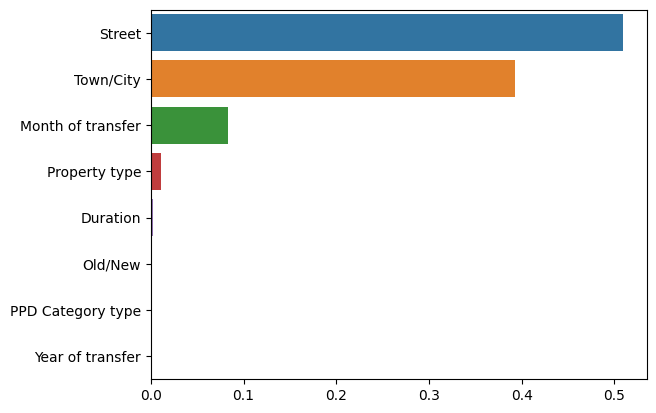

In [107]:
sns.barplot(y=importances.index, x=importances, orient="h")
pass